In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import display
from IPython.display import SVG

import statsmodels.formula.api as sm

# Post-Double-Selection Lasso

In [2]:
# load lending club data and clean up
df = pd.read_csv('../Data/lendingclub_cleaned/Loan_data.csv', low_memory = False)
df = df.drop(['zip_code', 'addr_state', 'purpose', 'home_ownership', 'fico_range_low'], axis =1)
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x =='Fail' else 0)

In [3]:
# define control variables
X = df[list(set(df.columns) - set(['id', 'loan_status', 'int_rate']))]
print(list(X.columns))

# define treatment variable
W = df['int_rate']

# define outcome variable
y = df['loan_status']

['open_rv_24m', 'tax_liens', 'loan_amnt', 'delinq_amnt', 'total_bal_il', 'revol_bal', 'max_bal_bc', 'total_bc_limit', 'percent_bc_gt_75', 'term', 'revol_util', 'pub_rec', 'open_rv_12m', 'num_il_tl', 'emp_length', 'num_rev_accts', 'total_bal_ex_mort', 'num_actv_bc_tl', 'pymnt_plan', 'earliest_cr_line', 'open_il_24m', 'annual_inc', 'num_op_rev_tl', 'total_acc', 'tot_hi_cred_lim', 'verification_status', 'inq_last_6mths', 'grade', 'sub_grade', 'fico_range_high', 'application_type', 'avg_cur_bal', 'num_accts_ever_120_pd', 'installment', 'pub_rec_bankruptcies', 'delinq_2yrs', 'tot_cur_bal', 'num_tl_90g_dpd_24m', 'dti', 'num_bc_tl', 'inq_last_12m', 'open_il_12m', 'open_act_il']


In [4]:
def selection_lasso(X,y):
    # cross validate the regularisation parameter alpha
    param_grid = [{'alpha' : 10.0**-np.arange(1,7)}]
    Lasso_reg = Lasso(normalize =True)
    clf = GridSearchCV(Lasso_reg, param_grid,cv=5, n_jobs = -1)
    clf.fit(X,y)
    alpha = clf.best_params_['alpha']
    
    # fit the model with the best alpha
    Lasso_reg = Lasso(normalize =True, alpha =alpha)
    Lasso_reg.fit(X,y)
    
    # make list of variables with positive coefficient
    df_coefs = pd.DataFrame(Lasso_reg.coef_, index = X.columns.T, columns = ['Value'])
    to_keep = list(df_coefs[df_coefs['Value']>0].index)

    return to_keep, df_coefs, alpha

def run_ols(df,controls):
    formula = 'loan_status ~ int_rate +'+'+ '.join(controls)
    result = sm.ols(formula=formula, data=df).fit()
    print(result.summary())
    return result

In [5]:
# exercise: execute a double LASSO to find the treatment effect of interest rates on loan status

# two LASSO steps to find confounders (2 lines of code)

# make list of all control variables to keep (one line of code)

# one OLS step to get results (1 line of code)


In [6]:
# %load solution_doubleLASSO.py
# two LASSO steps to find confounders (2 lines of code)
to_keep_1,_,_ = selection_lasso(X,y)
print(to_keep_1)
to_keep_2,_,_ = selection_lasso(X,W)
print(to_keep_2)

# make list of all control variables to keep (one line of code)
controls = list(set(to_keep_1+to_keep_2))
print('The controls are:',', '.join(controls))

# one OLS step to get results
result = run_ols(df,controls)

['open_rv_24m', 'tax_liens', 'open_rv_12m', 'num_actv_bc_tl', 'pymnt_plan', 'open_il_24m', 'verification_status', 'inq_last_6mths', 'grade', 'sub_grade', 'fico_range_high', 'application_type', 'installment', 'num_tl_90g_dpd_24m', 'num_bc_tl', 'inq_last_12m', 'open_il_12m']
['delinq_amnt', 'total_bc_limit', 'term', 'pub_rec', 'emp_length', 'num_actv_bc_tl', 'pymnt_plan', 'annual_inc', 'total_acc', 'tot_hi_cred_lim', 'grade', 'sub_grade', 'fico_range_high', 'avg_cur_bal', 'num_accts_ever_120_pd', 'installment', 'pub_rec_bankruptcies', 'num_tl_90g_dpd_24m', 'open_act_il']
The controls are: open_rv_24m, tax_liens, delinq_amnt, total_bc_limit, term, pub_rec, open_rv_12m, emp_length, num_actv_bc_tl, pymnt_plan, open_il_24m, annual_inc, total_acc, tot_hi_cred_lim, verification_status, inq_last_6mths, grade, sub_grade, fico_range_high, application_type, avg_cur_bal, num_accts_ever_120_pd, installment, pub_rec_bankruptcies, num_tl_90g_dpd_24m, num_bc_tl, open_act_il, inq_last_12m, open_il_12m
 

# Causal Trees with sample splitting

In [7]:
# load lending club data and clean up
df = pd.read_csv('../Data/lendingclub_cleaned/Loan_data.csv', low_memory = False)
df = df.drop(['zip_code', 'addr_state', 'purpose', 'home_ownership', 'fico_range_low'], axis =1)
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x =='Fail' else 0)

# Create the quintiles and the sample
df['quintile_rate'] = pd.qcut(df['int_rate'], 5, labels=False)
df['high_rate'] =df['quintile_rate'] == 4
df['low_rate'] =df['quintile_rate'] == 0

df = df[(df['high_rate'] ==1)  | (df['low_rate'] ==1)]
df.drop(['quintile_rate', 'int_rate', 'low_rate'], axis =1, inplace = True)
df.drop(['pymnt_plan', 'grade', 'sub_grade'], axis =1, inplace = True)

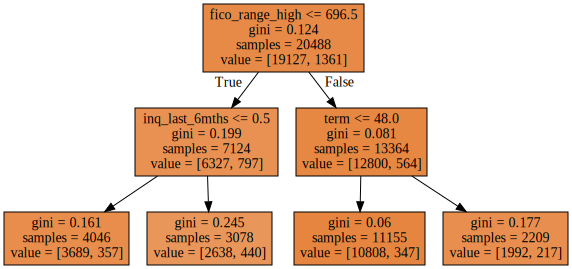

In [8]:
# sample splitting
df_sample = df.sample(frac=0.5, replace=False, random_state  = 12)
df_sample_2 = df[~df.index.isin(list(df_sample.index))]

# set up sample for fitting tree
X = df_sample[list(set(df.columns) - set(['id', 'loan_status', 'high_rate']))]
y =  df_sample['loan_status']

# fit tree and visualize
clf = DecisionTreeClassifier(max_depth  = 2)
clf.fit(X, y)
graph = Source(export_graphviz(clf, out_file=None, feature_names=X.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

In [9]:
pd.options.mode.chained_assignment = None
df_sample_2['cat_1'] = (df_sample_2['fico_range_high'] <=696.5) & (df_sample_2['inq_last_6mths'] <=0.5)
df_sample_2['cat_2'] = (df_sample_2['fico_range_high'] <=696.5) & (df_sample_2['inq_last_6mths'] >0.5)
df_sample_2['cat_3'] = (df_sample_2['fico_range_high'] > 696.5) & (df_sample_2['term'] <=48)
df_sample_2['cat_4'] = (df_sample_2['fico_range_high'] > 696.5) & (df_sample_2['term'] >48)

In [10]:
df_sample_2.head()

,id,loan_status,loan_amnt,term,installment,annual_inc,emp_length,dti,fico_range_high,verification_status,...,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,high_rate,cat_1,cat_2,cat_3,cat_4
5,126412156,0,16000.0,60,477.35,51000.0,10,27.53,679.0,1,...,84716.0,11.0,61155.0,48957.0,9600.0,True,True,False,False,False
9,126370010,0,7500.0,36,230.62,62500.0,10,10.60,744.0,1,...,35100.0,19.0,17347.0,10818.0,5000.0,False,False,False,True,False
11,126383239,0,10000.0,60,286.99,42000.0,10,31.17,664.0,1,...,42900.0,20.0,34122.0,0.0,27100.0,True,True,False,False,False
16,126068485,0,20000.0,60,656.81,254000.0,10,16.86,669.0,2,...,666222.0,63.0,101169.0,41202.0,41700.0,True,False,True,False,False
25,126285300,0,40000.0,36,1218.33,100000.0,0,11.21,784.0,1,...,457900.0,18.0,58049.0,36992.0,56000.0,False,False,False,True,False


In [11]:
import statsmodels.api as sm

for i in range(1,5):
    print('***** node %d ******\n' % i)
    dta = df_sample_2[df_sample_2['cat_'+str(i)]==True]
    y = dta['loan_status']
    X = dta['high_rate'].astype('int')
    X = sm.add_constant(X)
    res = sm.OLS(y,X).fit()
    print(res.summary())

***** node 1 ******

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     65.22
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           8.71e-16
Time:                        14:23:27   Log-Likelihood:                -831.43
No. Observations:                4175   AIC:                             1667.
Df Residuals:                    4173   BIC:                             1680.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0241      0.01

In [12]:
i=1
print('***** node %d ******\n' % i)
dta = df_sample_2[df_sample_2['cat_'+str(i)]==True]
y = dta['loan_status']
X = dta['high_rate'].astype('int')
X = sm.add_constant(X)
res = sm.OLS(y,X).fit()
print(res.summary())

***** node 1 ******

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     65.22
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           8.71e-16
Time:                        14:23:27   Log-Likelihood:                -831.43
No. Observations:                4175   AIC:                             1667.
Df Residuals:                    4173   BIC:                             1680.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0241      0.01